References <br>
https://github.com/pashupati98/text-classification

Glove word embeddings from https://www.kaggle.com/datasets/watts2/glove6b50dtxt

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
% matplotlib inline

In [26]:
import re
from io import StringIO
import pandas as pd

data_path = '/content/Suicide_Detection_Cleaned_10000.csv'
df = pd.read_csv(data_path)
df = df.drop(df.columns[0], axis=1) # Drop the first index column

In [27]:
print(df.shape)
df.head()

(10000, 2)


,text,class
0,ex wife threaten suiciderecently leave wife go...,1
1,weird get affect compliment come someone know ...,0
2,finally two thousand and twenty almost never h...,0
3,need helpjust help cry hard,1
4,iam losthello name adam sixteen iave struggle ...,1


In [6]:
from keras.layers import Dropout, Dense, GRU, Embedding, LSTM, TimeDistributed, Flatten
from keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [7]:
def loadData_Tokenizer(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    embeddings_index = {}
    f = open("/content/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return (X_train, X_test, word_index,embeddings_index)

In [8]:
def Build_Model_RNN_Text(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    """
    def buildModel_RNN(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    word_index in word index ,
    embeddings_index is embeddings index, look at data_helper.py
    nClasses is number of classes,
    MAX_SEQUENCE_LENGTH is maximum lenght of text sequences
    """
    model = Sequential()
    hidden_layer = 3
    lstm_node = 32
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    print(lstm_node)
    for i in range(0,hidden_layer):
        model.add(LSTM(lstm_node,return_sequences=True, recurrent_dropout=0.2))
        model.add(Dropout(dropout))
    model.add(LSTM(lstm_node, recurrent_dropout=0.2))
    model.add(Dropout(dropout))
    #model.add(TimeDistributed(Dense(256)))
    #model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [36]:
def experiment(df):
  print("Running Experiment ... ")
  X = df['text']
  y = df['class']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
  print("Generating Glove ...")
  X_train_Glove,X_test_Glove, word_index,embeddings_index = loadData_Tokenizer(X_train,X_test)
  with warnings.catch_warnings():
    print("Building Model ...")
    model_RNN = Build_Model_RNN_Text(word_index,embeddings_index, 2)
    model_RNN.summary()
    print("\n Starting Training ... \n")
    history = model_RNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=7,
                              batch_size=128,
                              verbose=1)
    warnings.simplefilter("ignore")
  print("\n Plotting results ... \n")
  plot_graphs(history, 'accuracy')
  plot_graphs(history, 'loss')
  print("\n Evaluating Model ... \n")
  predicted = model_RNN.predict(X_test_Glove)
  predicted = np.argmax(predicted, axis=1)
  #print(predicted)
  print(metrics.classification_report(y_test, predicted))
  print("\n")
  logger = logging.getLogger("logger")
  result = compute_metrics(y_test, predicted)
  for key in (result.keys()):
      logger.info("  %s = %s", key, str(result[key]))
  return model_RNN

In [10]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "pricision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

def class_balance(df, target):
  cls = df[target].value_counts()
  cls.plot(kind='bar')
  plt.show()

### Experiment with RDF

In [28]:
solid = shuffle(df)

Running Experiment ... 
Generating Glove ...
Found 26709 unique tokens.
(10000, 500)
Total 400000 word vectors.
Building Model ...
32


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 500, 50)           1335500   
                                                                 
 lstm_16 (LSTM)              (None, 500, 32)           10624     
                                                                 
 dropout_16 (Dropout)        (None, 500, 32)           0         
                                                                 
 lstm_17 (LSTM)              (None, 500, 32)           8320      
                                                                 
 dropout_17 (Dropout)        (None, 500, 32)           0         
                                                                 
 lstm_18 (LSTM)              (None, 500, 32)           8320      
                                                                 
 dropout_18 (Dropout)        (None, 500, 32)          

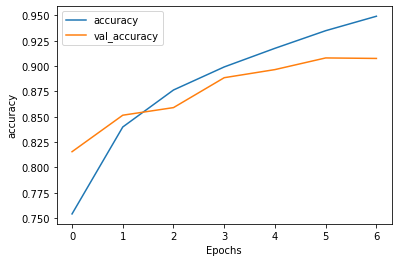

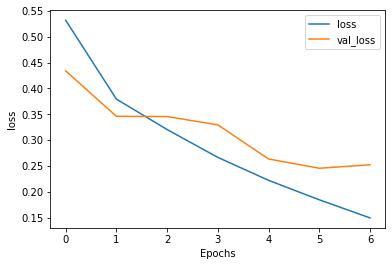


 Evaluating Model ... 



INFO:logger:  mcc = 0.8149357795498754
INFO:logger:  tp = 875
INFO:logger:  tn = 940
INFO:logger:  fp = 101
INFO:logger:  fn = 84
INFO:logger:  pricision = 0.8965163934426229
INFO:logger:  recall = 0.9124087591240876
INFO:logger:  F1 = 0.9043927648578811
INFO:logger:  accuracy = 0.9075


              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1041
           1       0.90      0.91      0.90       959

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000





In [37]:
model = experiment(solid)

In [45]:
model.save('/content/model')

INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


### Do Prediction on Local Test Data

In [39]:
local_data_path = '/content/local_data_clean.csv'
ldf = pd.read_csv(local_data_path)
ldf = ldf.drop(ldf.columns[0], axis=1) # Drop the first index column
print(ldf.shape)
ldf.head()

(46, 2)


,text,class
0,pain never go become anything never go live wa...,1
1,suicidal thoughts every single day years gener...,1
2,much pain everything hurt much go take life ma...,1
3,plan spend time family much possible next mont...,1
4,get make look like accident want family miss i...,1


In [40]:
def convert_to_embeddings(X, MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    text = np.array(X)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    embeddings_index = {}
    f = open("/content/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return (text, word_index,embeddings_index)

In [41]:
text, word_index, embeddings_index = convert_to_embeddings(ldf['text'])

Found 1108 unique tokens.
(46, 500)
Total 400000 word vectors.


In [44]:
import time
single_text = text[:1]
single_text.shape

tries = []
for i in range(20):
  start = time.time()
  single_predicted = model.predict(single_text)
  end = time.time()
  tries.append(end-start)
print("Average time taken: ", sum(tries) / len(tries))

Average time taken:  0.9643936634063721


In [43]:
predicted = model.predict(text)
predicted = np.argmax(predicted, axis=1)

y_test = ldf['class']

print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))

INFO:logger:  mcc = 0.5222329678670935
INFO:logger:  tp = 18
INFO:logger:  tn = 17
INFO:logger:  fp = 6
INFO:logger:  fn = 5
INFO:logger:  pricision = 0.75
INFO:logger:  recall = 0.782608695652174
INFO:logger:  F1 = 0.7659574468085107
INFO:logger:  accuracy = 0.7608695652173914


              precision    recall  f1-score   support

           0       0.77      0.74      0.76        23
           1       0.75      0.78      0.77        23

    accuracy                           0.76        46
   macro avg       0.76      0.76      0.76        46
weighted avg       0.76      0.76      0.76        46



